# Music Genre Classifier

Notebook to explore the use of machine learning methods in classifying the genres of songs

### Data import

Import necessary libraries

In [150]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from adjustText import adjust_text
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform
import matplotlib.cm as cm


Download and read data

In [151]:
# Download data from HuggingFace
def download_data():
    df = pd.read_csv(
        "hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv"
    ).iloc[:, 1:]
    df.to_csv("spotify_data.csv", index=False)
    return


# Call function to download data
# download_data()

# Read file
df = pd.read_csv("spotify_data.csv")

## Exploratory data analysis

Check correlations between numeric features

In [152]:
# Extract numeric data
numeric_columns = [
    "popularity",
    "duration_ms",
    "danceability",
    "energy",
    "loudness",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
]

# Build the numeric dataframe
numeric_df = df[numeric_columns]
numeric_df.describe()

,popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,33.238535,2.280292e+05,0.566800,0.641383,-8.258960,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837
std,22.305078,1.072977e+05,0.173542,0.251529,5.029337,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197
min,0.000000,0.000000e+00,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.740660e+05,0.456000,0.472000,-10.013000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750
50%,35.000000,2.129060e+05,0.580000,0.685000,-7.004000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000
75%,50.000000,2.615060e+05,0.695000,0.854000,-5.003000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000
max,100.000000,5.237295e+06,0.985000,1.000000,4.532000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000


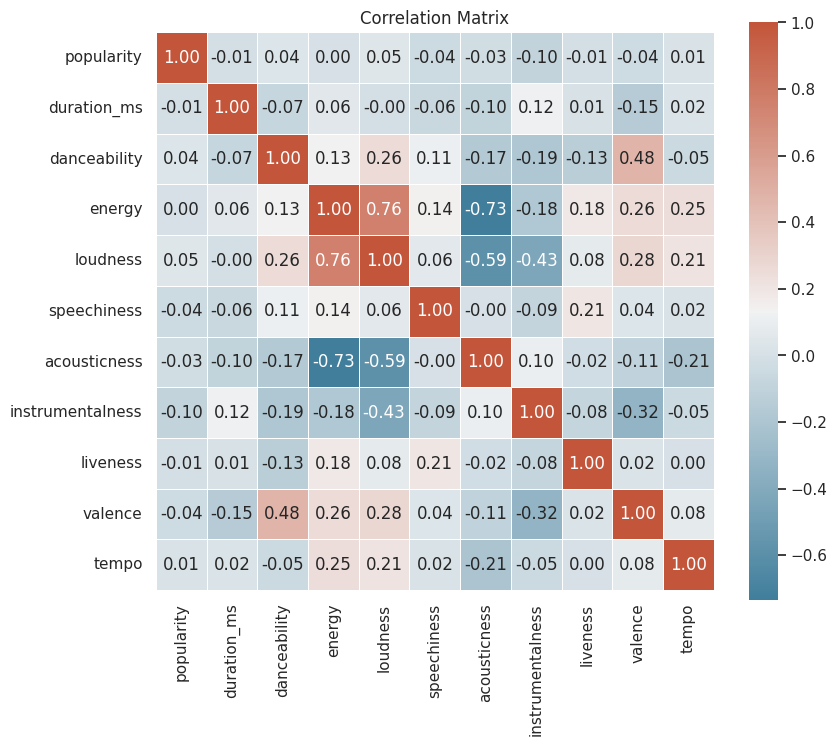

In [153]:
# Create a larger figure
plt.figure(figsize=(9, 7.5))

# Plot title
plt.title("Correlation Matrix")

# Compute the correlation matrix
corr = numeric_df.corr()

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask
sns.heatmap(corr, annot=True, fmt=".2f", linewidths=0.5, cmap=cmap, square=True)

# Display the plot
plt.show()


Investigate how different features vary by musical genre 

Text(0, 0.5, 'Loudness Index')

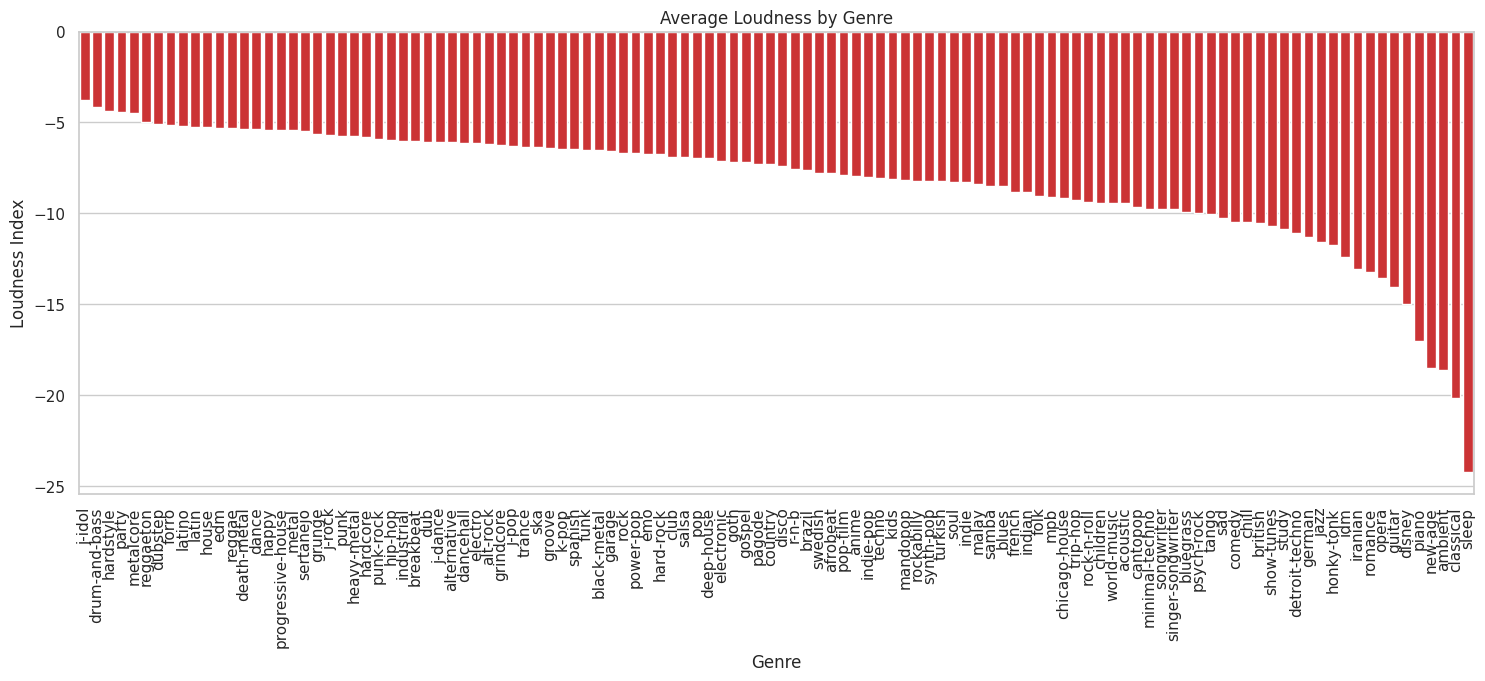

In [154]:
# Obtain averages by genre in the dataset
average_df = df.groupby('track_genre').mean(numeric_only =True)

# Sort the DataFrame by mean loudness
average_df = average_df.sort_values(by='loudness', ascending=False)

# Create a large-sized plot
plt.figure(figsize=(18, 6))
sns.barplot(x=average_df.index, y='loudness', data=average_df)
plt.xticks(rotation=90)  # Rotate labels for better fit

# Title and axis
plt.title('Average Loudness by Genre')
plt.xlabel('Genre')
plt.ylabel('Loudness Index')

Text(0, 0.5, 'Popularity')

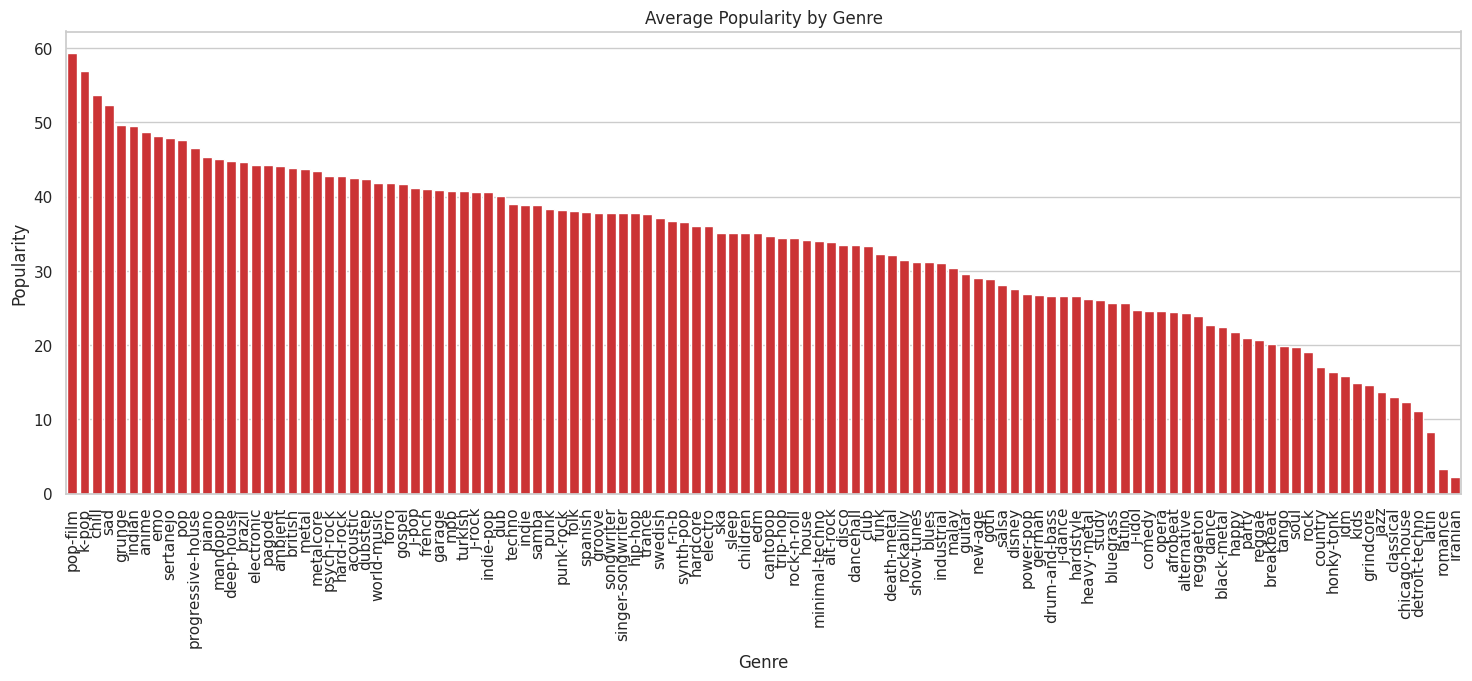

In [155]:
# Sort the DataFrame by mean loudness
average_df = average_df.sort_values(by='popularity', ascending=False)

# Create a large-sized plot
plt.figure(figsize=(18, 6))
sns.barplot(x=average_df.index, y='popularity', data=average_df)
plt.xticks(rotation=90)  # Rotate labels for better fit

# Title and axis
plt.title('Average Popularity by Genre')
plt.xlabel('Genre')
plt.ylabel('Popularity')

Check whether features vary by time signature. The presence of time signatures "0" and "1" as separate categories doesn't make sense to me musically. One or the other may represent songs with no regular beat.

Text(0, 0.5, 'Popularity')

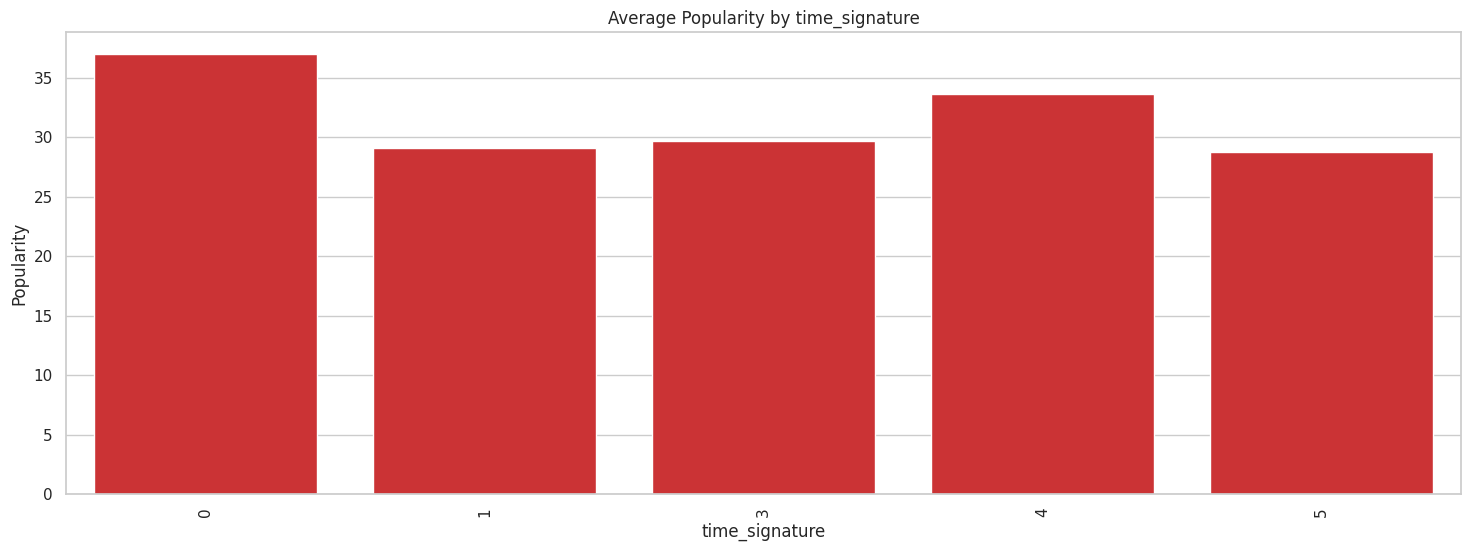

In [156]:
average_df = df.groupby('time_signature').mean(numeric_only =True)

# Sort the DataFrame by mean loudness
average_df = average_df.sort_values(by='loudness', ascending=False)

# Create a large-sized plot
plt.figure(figsize=(18, 6))
sns.barplot(x=average_df.index, y='popularity', data=average_df)
plt.xticks(rotation=90)  # Rotate labels for better fit

# Title and axis
plt.title('Average Popularity by time_signature')
plt.xlabel('time_signature')
plt.ylabel('Popularity')

Text(53.74999999999999, 0.5, 'Track Genre')

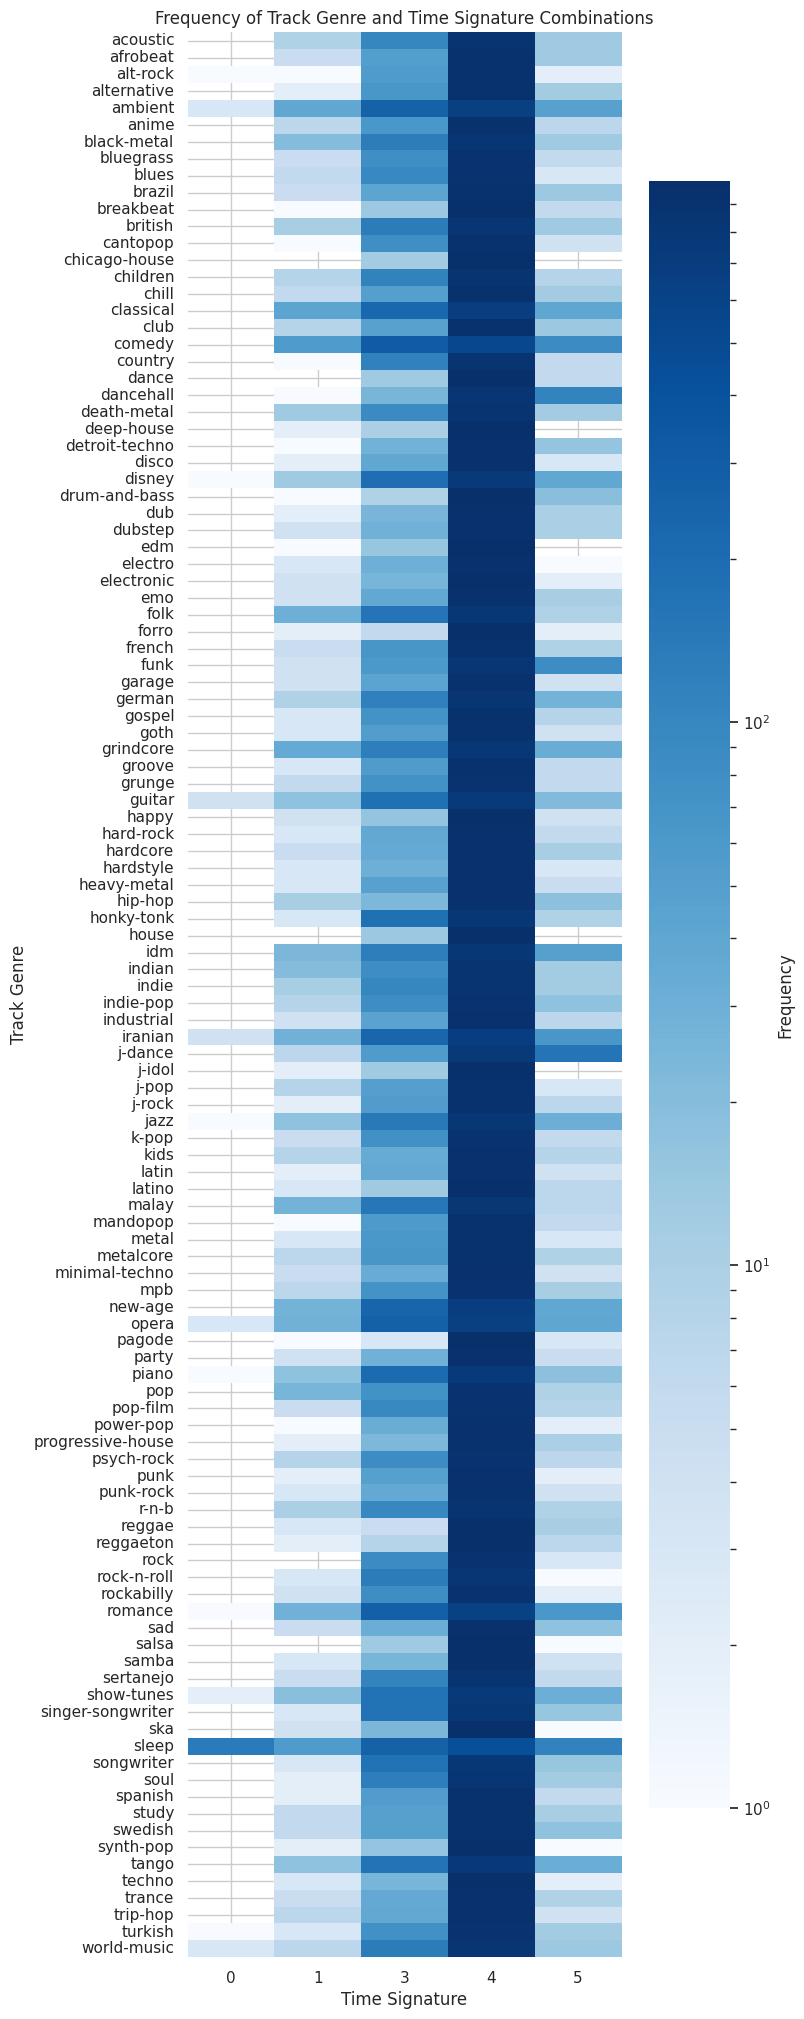

In [157]:
from matplotlib.colors import LogNorm

freq_table = pd.crosstab(df['track_genre'], df['time_signature'])

# Create heatmap
plt.figure(figsize=(7, 25))
sns.heatmap(freq_table, annot=False, fmt='d', cmap='Blues', cbar_kws={'label': 'Frequency'},norm=LogNorm())
plt.title('Frequency of Track Genre and Time Signature Combinations')
plt.xlabel('Time Signature')
plt.ylabel('Track Genre')
# plt.show()


## Data preparation

Drop duplicate rows

In [158]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(114000, 20)
(113550, 20)


Drop features not relevant to classification

In [159]:
# Drop non explanatory features
df = df.drop(columns = ['track_id','artists','album_name','track_name'])

Check values in time signature column

In [160]:
display(df.time_signature.value_counts())
# display(df.loc[df['time_signature'] == 1])

time_signature
4    101487
3      9128
5      1805
1       967
0       163
Name: count, dtype: int64

Transform categorical variables into numerical representation through one-hot encoding

In [161]:
# Map the explicit column to binary values
df['explicit'] = df['explicit'].map({False: 0,True: 1})

# Perform one-hot encoding
df = pd.get_dummies(df, columns=['key'], prefix = 'key', drop_first=True)
df = pd.get_dummies(df, columns=['time_signature'], prefix = 'meter', drop_first=True)

Save dataframe with unscaled numerical values for future use

In [162]:
df_unscaled = df

Scale numerical features

In [163]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Scaling function
def perform_scaling(df, columns_to_scale, scaler_type):
    # scaler_type == 1 for StandardScaler, 2 for MinMaxScaler
    if scaler_type == 1:
        scaler = StandardScaler()
    elif scaler_type == 2:
        scaler = MinMaxScaler()
    else:
        raise ValueError("Invalid scaler_type. Use 1 for StandardScaler or 2 for MinMaxScaler.")

    scaled_data = scaler.fit_transform(df[columns_to_scale])
    scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)
    df_scaled = pd.concat([df.drop(columns=columns_to_scale).reset_index(drop=True), scaled_df], axis=1)

    return df_scaled
  
# Define numeric columns
numeric_cols = ["popularity","duration_ms","danceability","energy","loudness","speechiness","acousticness","instrumentalness","liveness","valence","tempo"]
  
# Perform Scaling
df = perform_scaling(df, numeric_cols, 1)

Apply hierachical clustering to dataset averaged by genre. Genres which share the most features appear closer together. Construct a dendrogram to visualise this clustering and choose an appropriate threshold value at which to group genres.

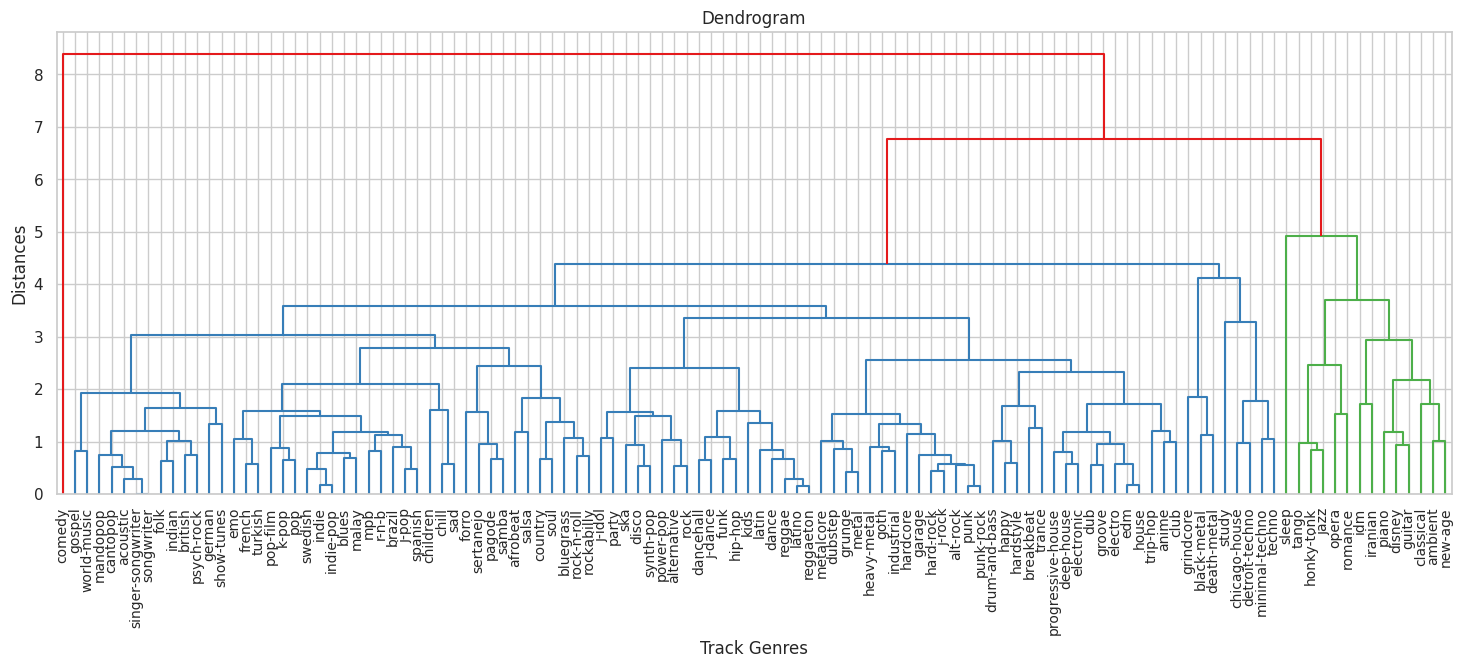

In [164]:
import scipy.cluster.hierarchy as sch

# Group by genre
genres_average = df.groupby('track_genre').mean()
# Perform hierarchical clustering
plt.figure(figsize=(18, 6))
dendrogram = sch.dendrogram(sch.linkage(genres_average, method='complete'), labels=genres_average.index)

# Show the dendrogram
plt.title('Dendrogram')
plt.xlabel('Track Genres')
plt.ylabel('Distances')

# Increase the size of x-labels
plt.tick_params(axis='x', labelsize=10)

# Show the plot
plt.show()

Choose a threshold by eye of 1. Produce the final clusters in the form of a dictionary using fclusters.

In [165]:
from scipy.cluster.hierarchy import fcluster

# Perform hierarchical clustering
linkage_matrix = sch.linkage(genres_average, method='complete')

# Specify the distance threshold
threshold = 1

# Extract the cluster labels based on the threshold
clusters = fcluster(linkage_matrix, threshold, criterion='distance')

# Add cluster labels to the original DataFrame
genres_average['Cluster'] = clusters

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 60)

# Create a dictionary to store classes and clusters
cluster_dict = {}
for i, (cluster, category) in enumerate(zip(clusters, genres_average.index)):
    if cluster not in cluster_dict:
        cluster_dict[cluster] = []
    cluster_dict[cluster].append(category)

ordered_cluster_dict = dict(sorted(cluster_dict.items()))

# Display the dictionary sorted by cluster    
ordered_cluster_dict

{np.int32(1): ['gospel', 'world-music'],
 np.int32(2): ['acoustic',
  'cantopop',
  'mandopop',
  'singer-songwriter',
  'songwriter'],
 np.int32(3): ['folk', 'indian'],
 np.int32(4): ['british', 'psych-rock'],
 np.int32(5): ['german'],
 np.int32(6): ['show-tunes'],
 np.int32(7): ['french', 'turkish'],
 np.int32(8): ['emo'],
 np.int32(9): ['k-pop', 'pop', 'pop-film'],
 np.int32(10): ['blues', 'indie', 'indie-pop', 'malay', 'swedish'],
 np.int32(11): ['mpb', 'r-n-b'],
 np.int32(12): ['brazil', 'j-pop', 'spanish'],
 np.int32(13): ['chill', 'sad'],
 np.int32(14): ['children'],
 np.int32(15): ['pagode', 'samba', 'sertanejo'],
 np.int32(16): ['forro'],
 np.int32(17): ['afrobeat'],
 np.int32(18): ['salsa'],
 np.int32(19): ['country', 'soul'],
 np.int32(20): ['rock-n-roll', 'rockabilly'],
 np.int32(21): ['bluegrass'],
 np.int32(22): ['j-idol'],
 np.int32(23): ['party'],
 np.int32(24): ['disco', 'ska', 'synth-pop'],
 np.int32(25): ['alternative', 'rock'],
 np.int32(26): ['power-pop'],
 np.int3

Manually provide descriptive labels for new clusters

In [166]:
consolidated_genres = {'roots': ['gospel', 'world-music'],
 'vocal-pop': ['acoustic',
  'cantopop',
  'mandopop',
  'singer-songwriter',
  'songwriter'],
 'world-folk': ['folk', 'indian'],
 'wavy-rock': ['british', 'psych-rock'],
 'france-and-diaspora': ['french', 'turkish'],
 'pop': ['k-pop', 'pop', 'pop-film'],
 'indie-and-blues': ['blues', 'indie', 'indie-pop', 'malay', 'swedish'],
 'rnb': ['mpb', 'r-n-b'],
'world-pop': ['brazil', 'j-pop', 'spanish'],
 'laid-back': ['chill', 'sad'],
 'world-rhythm': ['pagode', 'samba', 'sertanejo'],
 'country-soul': ['country', 'soul'],
 'rock-n-roll': ['rock-n-roll', 'rockabilly'],
 'disco-ska': ['disco', 'ska', 'synth-pop'],
 'alt-rock': ['alternative', 'rock'],
 'j-dancehall': ['dancehall', 'j-dance'],
 'funk-hip-hop': ['funk', 'hip-hop'],
 'latin-dance': ['dance', 'latin', 'latino', 'reggae', 'reggaeton'],
 'heavy-grunge': ['dubstep', 'grunge', 'metal'],
 'heavy-rock': ['goth', 'heavy-metal', 'industrial'],
 'punk-rock': ['alt-rock',
  'garage',
  'hard-rock',
  'j-rock',
  'punk',
  'punk-rock'],
 'hardcore-happy': ['happy', 'hardstyle'],
 'deep-electronic': ['deep-house', 'electronic', 'progressive-house'],
 'groovy-electronic': ['dub', 'edm', 'electro', 'groove', 'house'],
 'anime-club': ['anime', 'club'],
 'us-techno-house': ['chicago-house', 'detroit-techno'],
 'jazz-tango': ['honky-tonk', 'jazz', 'tango'],
 'disney-guitar': ['disney', 'guitar']}

Remap clustered genre names in dataframe

In [167]:
# Create a dictionary to map old genres to new genres
genre_map = {old_genre: new_genre for new_genre, old_genres in consolidated_genres.items() for old_genre in old_genres}

# Replace the old genres with the new genres
df['track_genre'] = df['track_genre'].replace(genre_map)
df_unscaled['track_genre'] = df_unscaled['track_genre'].replace(genre_map)

Label-encode genres

In [168]:
from sklearn.preprocessing import LabelEncoder

# Define the target and explanatory features
X = df.drop("track_genre", axis=1).values
y = df["track_genre"].values
print(X[0])

# Perform Label Encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Store the genres encoded in the label encoder
genres = label_encoder.classes_

[0 0 True False False False False False False False False False False
 False False True False 1.7804737984721293 0.024307235575649847
 0.628399386364962 -0.7213285156798409 0.29880373956282197
 0.5514877449974813 -0.849239124843407 -0.5035357667369038
 0.758101884333877 0.9289747300244748 -1.143001944482043]


Perform train-test split

In [169]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=422)

# Transform the train and test data into float
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

## Train neural networks

In [170]:
import tensorflow as tf
from tensorflow import keras

# Define the number of classes and input features
num_classes = len(label_encoder.classes_)
inputs = keras.Input(shape=(X_train.shape[1],))

# Build the layers
nn_model = keras.Sequential([
    inputs,
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(num_classes, activation='softmax')])

# Define the accuracy metric
sparse_topK_categorical_accuracy = keras.metrics.SparseTopKCategoricalAccuracy(k = 3)

# Compile the model
nn_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=[sparse_topK_categorical_accuracy])

# Train the model
nn_model.fit(X_train, y_train, epochs=60, batch_size=128, validation_data=(X_test, y_test))

# Make predictions
y_pred_nn = nn_model.predict(X_test)

Epoch 1/60
710/710 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.7170 - sparse_top_k_categorical_accuracy: 0.2364 - val_loss: 3.3073 - val_sparse_top_k_categorical_accuracy: 0.3419
Epoch 2/60
710/710 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.0411 - sparse_top_k_categorical_accuracy: 0.4071 - val_loss: 2.8957 - val_sparse_top_k_categorical_accuracy: 0.4458
Epoch 3/60
710/710 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.7925 - sparse_top_k_categorical_accuracy: 0.4715 - val_loss: 2.7585 - val_sparse_top_k_categorical_accuracy: 0.4835
Epoch 4/60
710/710 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.6913 - sparse_top_k_categorical_accuracy: 0.5024 - val_loss: 2.6845 - val_sparse_top_k_categorical_accuracy: 0.5065
Epoch 5/60
710/710 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.6276 - sparse_top_k_categorical_accuracy: 0.5184 - val_loss: 2.6336 - val_sparse_top_k_categorical_accuracy: 0.5192
Epoch 6/60
710/710 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 2.5810 - sparse_top_k_categorical_accuracy: 0.5316

In [171]:
import xgboost as xgb

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=num_classes, seed=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict_proba(X_test)

KeyboardInterrupt: 

In [ ]:
def top_k_accuracy(y_test, y_pred, k):
    # Calculate top-k categorical accuracy
    top_k_accuracy = tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_pred, k=k)
    top_k_accuracy = round(np.mean(top_k_accuracy)*100,2)

    # Calculate accuracy
    accuracy = tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_pred, k=1)
    accuracy = round(np.mean(accuracy)*100,2)

    print(f"Top-{k} categorical accuracy: {top_k_accuracy}%")
    print(f"Accuracy: {accuracy}%")
    
print("Neural Network Results:")
top_k_accuracy(y_test, y_pred_nn, 10)

print("XGBoost Results:")
top_k_accuracy(y_test, y_pred_xgb, 10)

Neural Network Results:
Top-10 categorical accuracy: 86.94000244140625%
Accuracy: 38.220001220703125%
XGBoost Results:
Top-10 categorical accuracy: 90.58000183105469%
Accuracy: 43.93000030517578%


## Get song features using spotify web API

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth

client_id = "16b4c529c53b403f8c059916fee1e6d7"
secret = "1eaf0c17e0b547c8a98172d1a79813bd"
redirect_uri='https://jacob-knight.com/'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id, client_secret=secret, redirect_uri=redirect_uri, scope='user-library-read user-top-read user-read-recently-played'))

In [ ]:
results = sp.current_user_saved_tracks()
for idx, item in enumerate(results['items']):
    track = item['track']
    print(idx, track['artists'][0]['name'], " – ", track['name'])

0 Labi Siffre  –  Summer Is Coming
1 Lalo Schifrin  –  Middle Of The Night
2 Marva Whitney  –  Nothing I'd Rather Be (Than Your Weakness)
3 Obongjayar  –  Moon Eyes
4 hard life  –  sangria
5 Bobby Wright  –  Blood Of An American
6 Chappell Roan  –  HOT TO GO!
7 The Jungle Giants  –  Sending Me Ur Loving
8 Alison Limerick  –  Where Love Lives
9 Obongjayar  –  Talk Olympics
10 Beastie Boys  –  Sure Shot
11 Phil Collins  –  Hand In Hand - 2015 Remastered
12 Lily Allen  –  LDN
13 Afro Medusa  –  Pasilda
14 Sander Kleinenberg  –  My Lexicon
15 Golden Girls  –  Kinetic - Orbital Mix
16 L.S.G.  –  Netherworld
17 Florence + The Machine  –  You've Got The Dirtee Love - Live At The Brit Awards / 2010
18 Florence + The Machine  –  Dog Days Are Over
19 Moodymann  –  Don’t You Want My Love


In [ ]:
results = sp.current_user_top_tracks(limit=20, offset=0, time_range='long_term')
for idx, item in enumerate(results['items']):
    print(idx+1, item['artists'][0]['name'], " – ", item['name'])

1 Lil Yachty  –  drive ME crazy!
2 Daryl Hall & John Oates  –  Rich Girl
3 Mac Miller  –  100 Grandkids
4 The Meters  –  Loving You Is on My Mind
5 Aretha Franklin  –  You Send Me - 2018 Mono Remaster
6 Joomanji  –  I'm Fine (Interlude) [feat. Austin Antione & Jackie Owens]
7 Ebo Taylor  –  Will You Promise
8 Woody and Jeremy  –  Hollywood Witches
9 B.B. King  –  Better Not Look Down
10 Aretha Franklin  –  Day Dreaming
11 Aaron Frazer  –  If I Got It (Your Love Brought It)
12 Hot Chip  –  Atomic Bomb - Cover
13 Boz Scaggs  –  Lowdown (2023 Remaster)
14 Womack & Womack  –  Teardrops - 7” Single Version
15 J A Y E L E C T R O N I C A  –  Fruits Of The Spirit
16 Stevie Wonder  –  All I Do
17 Otis Gayle  –  I'll Be Around
18 Cymande  –  Changes
19 Courtney John  –  Lucky Man
20 Barry White  –  Can't Get Enough Of Your Love, Babe


In [ ]:
results = sp.current_user_recently_played(limit=10)
for idx, item in enumerate(results['items']):
    track = item['track']
    print(idx, track['artists'][0]['name'], " – ", track['name'])

0 Say She She  –  Trouble
1 Say She She  –  Trouble
2 Cleo Sol  –  23
3 Loyle Carner  –  Ain't Nothing Changed
4 Oscar Jerome  –  Do You Really
5 Labi Siffre  –  Summer Is Coming
6 Lalo Schifrin  –  Middle Of The Night
7 Marva Whitney  –  Nothing I'd Rather Be (Than Your Weakness)
8 Olivia Dean  –  Time
9 Oscar Jerome  –  Sun For Someone


Spotify API audio-features function is deprecated. Use an alternative API from rapidapi.com

In [ ]:
import http.client

conn = http.client.HTTPSConnection("track-analysis.p.rapidapi.com")

headers = {
    'x-rapidapi-key': "836e88688dmsh76cd2626c938ff5p15cd1ajsn0c8a40aaaa60",
    'x-rapidapi-host': "track-analysis.p.rapidapi.com"
}

conn.request("GET", "/pktx/analysis?song=Respect&artist=Aretha%20Franklin", headers=headers)

res = conn.getresponse()
data = res.read()

print(data.decode("utf-8"))

{"message":"You have exceeded the DAILY quota for Requests on your current plan, BASIC. Upgrade your plan at https:\/\/rapidapi.com\/soundnet-soundnet-default\/api\/track-analysis"}


In [ ]:
import ast

res = ast.literal_eval(data.decode("utf-8"))
print(list(res.keys()))

['message']


<unknown>:1: SyntaxWarning: invalid escape sequence '\/'


Create genre dashboard

In [172]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Choose features to be displayed on radar plot
audio_features = ['danceability', 'energy', 'valence', 'acousticness', 
                 'instrumentalness', 'speechiness', 'liveness']

# Calculate mean values for each genre
genre_profiles = df_unscaled.groupby('track_genre')[audio_features].mean()

genre_profiles_scaled = genre_profiles * 100


In [173]:
import ipywidgets as widgets
from IPython.display import display
import plotly.graph_objects as go

def create_ipywidgets_multi_genre_radar(genre_data):
    
    # Create multi-select widget
    genre_options = [(genre.title(), genre) for genre in genre_data.index]
    
    multi_select = widgets.SelectMultiple(
        options=genre_options,
        value=list(genre_data.index)[:3],  # Default selection
        description='Genres:',
        disabled=False,
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='300px', height='150px')
    )
    
    # Create output widget for the plot
    output = widgets.Output()
    
    def update_plot(change=None):

        # Update radar chart based on widget selection
        
        with output:
            output.clear_output(wait=True)
            
            selected_genres = multi_select.value
            if not selected_genres:
                print("Please select at least one genre")
                return
            
            fig = go.Figure()
            colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink']
            features = list(genre_data.columns)
            
            for i, genre in enumerate(selected_genres):
                values = list(genre_data.loc[genre])
                values_closed = values + [values[0]]
                features_closed = features + [features[0]]
                
                fig.add_trace(go.Scatterpolar(
                    r=values_closed,
                    theta=features_closed,
                    fill='toself',
                    name=genre.title(),
                    line_color=colors[i % len(colors)]
                ))
            
            fig.update_layout(
                polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
                title=f"Genre Comparison: {', '.join([g.title() for g in selected_genres])}",
                showlegend=True,
                height=600
            )
            
            fig.show()
    
    # Connect widget to update function
    multi_select.observe(update_plot, names='value')
    
    # Display widgets
    display(widgets.VBox([multi_select, output]))
    
    # Initial plot
    update_plot()

# Usage in Jupyter notebook
create_ipywidgets_multi_genre_radar(genre_profiles)


Plots to show which genres are most closely related to one another

/home/jacob/Documents/ml_practice/song_popularity_prediction/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9.



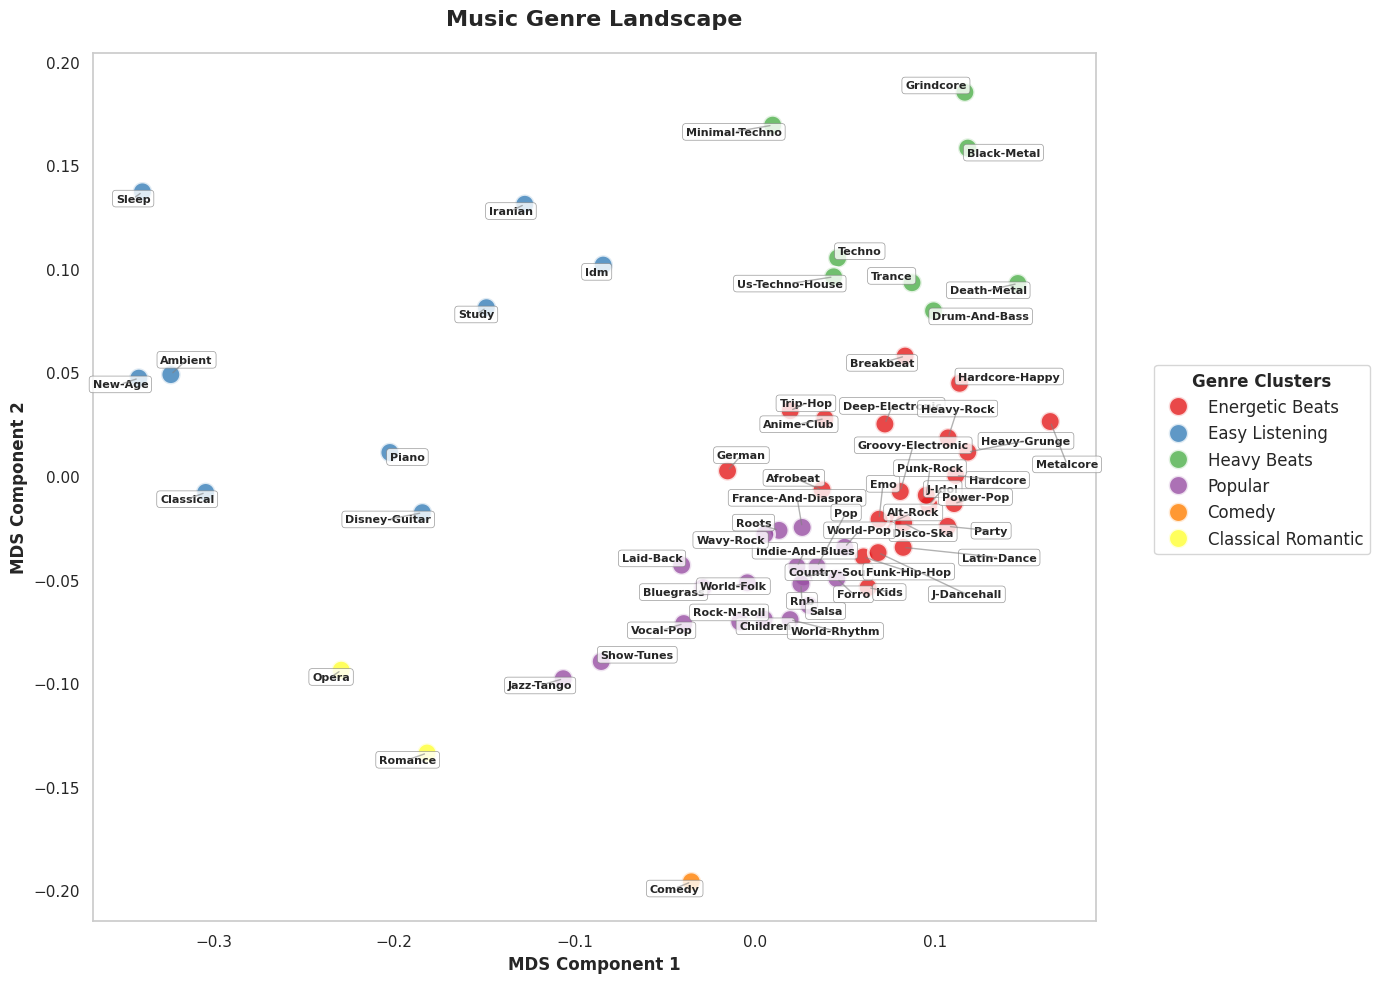

In [174]:
def create_mds_plot(genre_data, n_clusters=5):

    # Set seaborn style
    sns.set_theme(style="whitegrid", palette="Set1")
    
    # Perform clustering and MDS
    distance_matrix = pdist(genre_data, metric='cosine')
    distance_matrix_square = squareform(distance_matrix)
    
    linkage_matrix = linkage(distance_matrix, method='ward')
    cluster_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
    
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    mds_results = mds.fit_transform(distance_matrix_square)

    # Manually name clusters
    cluster_names = {
            1: "Easy Listening",
            2: "Classical Romantic", 
            3: "Popular",
            4: "Comedy",
            5: "Energetic Beats",
            6: "Heavy Beats"
        }
    
    # Create DataFrame
    plot_df = pd.DataFrame({
        'MDS_1': mds_results[:, 0],
        'MDS_2': mds_results[:, 1],
        'Genre': [genre.title() for genre in genre_data.index],
        'Cluster_Name': [cluster_names.get(label, f'Cluster {label}') for label in cluster_labels]
    })
    
    # Create the plot
    plt.figure(figsize=(14, 10))
    plt.grid(visible=False)
    
    ax = sns.scatterplot(
        data=plot_df,
        x='MDS_1', 
        y='MDS_2',
        hue='Cluster_Name',  
        s=200,
        alpha=0.8,
        edgecolor='white',
        linewidth=2
    )
    
    # Create text annotations 
    texts = []
    for i, row in plot_df.iterrows():
        text = ax.text(
            row['MDS_1'], 
            row['MDS_2'], 
            row['Genre'],
            fontsize=8,
            fontweight='bold',
            ha='center',
            va='center',
            bbox=dict(
                boxstyle='round,pad=0.3', 
                facecolor='white', 
                alpha=0.8,
                edgecolor='gray',
                linewidth=0.5
            )
        )
        texts.append(text)
    
    # Automatically adjust text positions to avoid overlap
    adjust_text(
        texts, 
        arrowprops=dict(
            arrowstyle='-', 
            color='gray', 
            alpha=0.6,
            lw=1
        ),
        expand_points=(1.2, 1.2),  # Expand around points
        expand_text=(1.1, 1.1),   # Expand around text
        force_points=0.5,         # Force away from points
        force_text=1.2,           # Force away from other text
        ax=ax
    )
    
    # Enhance plot styling
    ax.set_title(
        'Music Genre Landscape', 
        fontsize=16, 
        fontweight='bold',
        pad=20
    )
    ax.set_xlabel('MDS Component 1', fontsize=12, fontweight='semibold')
    ax.set_ylabel('MDS Component 2', fontsize=12, fontweight='semibold')
    
    # Legend
    legend = ax.legend(
        title='Genre Clusters',
        bbox_to_anchor=(1.05, 0.65), 
        fontsize=12, 
        loc='upper left',
        frameon=True,
        fancybox=True,
    )
    legend.get_title().set_fontweight('bold')
    
    # # Add stress information
    # stress_text = f'MDS Stress: {mds.stress_:.3f}'
    # ax.text(
    #     0.02, 0.98, stress_text,
    #     transform=ax.transAxes,
    #     fontsize=10,
    #     verticalalignment='top',
    #     bbox=dict(
    #         boxstyle="round,pad=0.5", 
    #         facecolor="lightblue", 
    #         alpha=0.8,
    #         edgecolor='navy'
    #     )
    # )
    
    plt.tight_layout()
    plt.show()
    
    return plot_df, mds.stress_

# Usage
clean_df, stress = create_mds_plot(genre_profiles_scaled, n_clusters=6)


In [175]:
# Create the dendrogram
plt.figure(figsize=(15, 8))
dendrogram_plot = dendrogram(
    linkage_matrix,
    labels=genre_profiles.index,
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True,
    color_threshold=2
)

plt.title('Music Genre Similarity Dendrogram')
plt.xlabel('Genres')
plt.ylabel('Distance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(visible=False)
plt.show()


TypeError: 'dict' object is not callable

<Figure size 1500x800 with 0 Axes>

In [176]:
genre_dict = clean_df.set_index('Genre')['Cluster_Name'].to_dict()
genre_dict =  {k.lower(): v for k, v in genre_dict.items()}
display(genre_dict)

{'afrobeat': 'Energetic Beats',
 'alt-rock': 'Energetic Beats',
 'ambient': 'Easy Listening',
 'anime-club': 'Energetic Beats',
 'black-metal': 'Heavy Beats',
 'bluegrass': 'Popular',
 'breakbeat': 'Energetic Beats',
 'children': 'Popular',
 'classical': 'Easy Listening',
 'comedy': 'Comedy',
 'country-soul': 'Popular',
 'death-metal': 'Heavy Beats',
 'deep-electronic': 'Energetic Beats',
 'disco-ska': 'Energetic Beats',
 'disney-guitar': 'Easy Listening',
 'drum-and-bass': 'Heavy Beats',
 'emo': 'Energetic Beats',
 'forro': 'Popular',
 'france-and-diaspora': 'Popular',
 'funk-hip-hop': 'Energetic Beats',
 'german': 'Energetic Beats',
 'grindcore': 'Heavy Beats',
 'groovy-electronic': 'Energetic Beats',
 'hardcore': 'Energetic Beats',
 'hardcore-happy': 'Energetic Beats',
 'heavy-grunge': 'Energetic Beats',
 'heavy-rock': 'Energetic Beats',
 'idm': 'Easy Listening',
 'indie-and-blues': 'Popular',
 'iranian': 'Easy Listening',
 'j-dancehall': 'Energetic Beats',
 'j-idol': 'Energetic Bea

In [179]:
df_unscaled['genre_category'] = df_unscaled['track_genre'].map(genre_dict)
display(df_unscaled)

,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,...,key_7,key_8,key_9,key_10,key_11,meter_1,meter_3,meter_4,meter_5,genre_category
0,73,230666,0,0.676,0.4610,-6.746,0,0.1430,0.0322,0.000001,...,False,False,False,False,False,False,False,True,False,Popular
1,55,149610,0,0.420,0.1660,-17.235,1,0.0763,0.9240,0.000006,...,False,False,False,False,False,False,False,True,False,Popular
2,57,210826,0,0.438,0.3590,-9.734,1,0.0557,0.2100,0.000000,...,False,False,False,False,False,False,False,True,False,Popular
3,71,201933,0,0.266,0.0596,-18.515,1,0.0363,0.9050,0.000071,...,False,False,False,False,False,False,True,False,False,Popular
4,82,198853,0,0.618,0.4430,-9.681,1,0.0526,0.4690,0.000000,...,False,False,False,False,False,False,False,True,False,Popular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0,0.172,0.2350,-16.393,1,0.0422,0.6400,0.928000,...,False,False,False,False,False,False,False,False,True,Popular
113996,22,385000,0,0.174,0.1170,-18.318,0,0.0401,0.9940,0.976000,...,False,False,False,False,False,False,False,True,False,Popular
113997,22,271466,0,0.629,0.3290,-10.895,0,0.0420,0.8670,0.000000,...,False,False,False,False,False,False,False,True,False,Popular
113998,41,283893,0,0.587,0.5060,-10.889,1,0.0297,0.3810,0.000000,...,True,False,False,False,False,False,False,True,False,Popular


In [180]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Choose features to be displayed on radar plot
audio_features = ['danceability', 'energy', 'valence', 'acousticness', 
                 'instrumentalness', 'speechiness', 'liveness']

# Calculate mean values for each genre
genre_profiles = df_unscaled.groupby('genre_category')[audio_features].mean()

genre_profiles_scaled = genre_profiles * 100


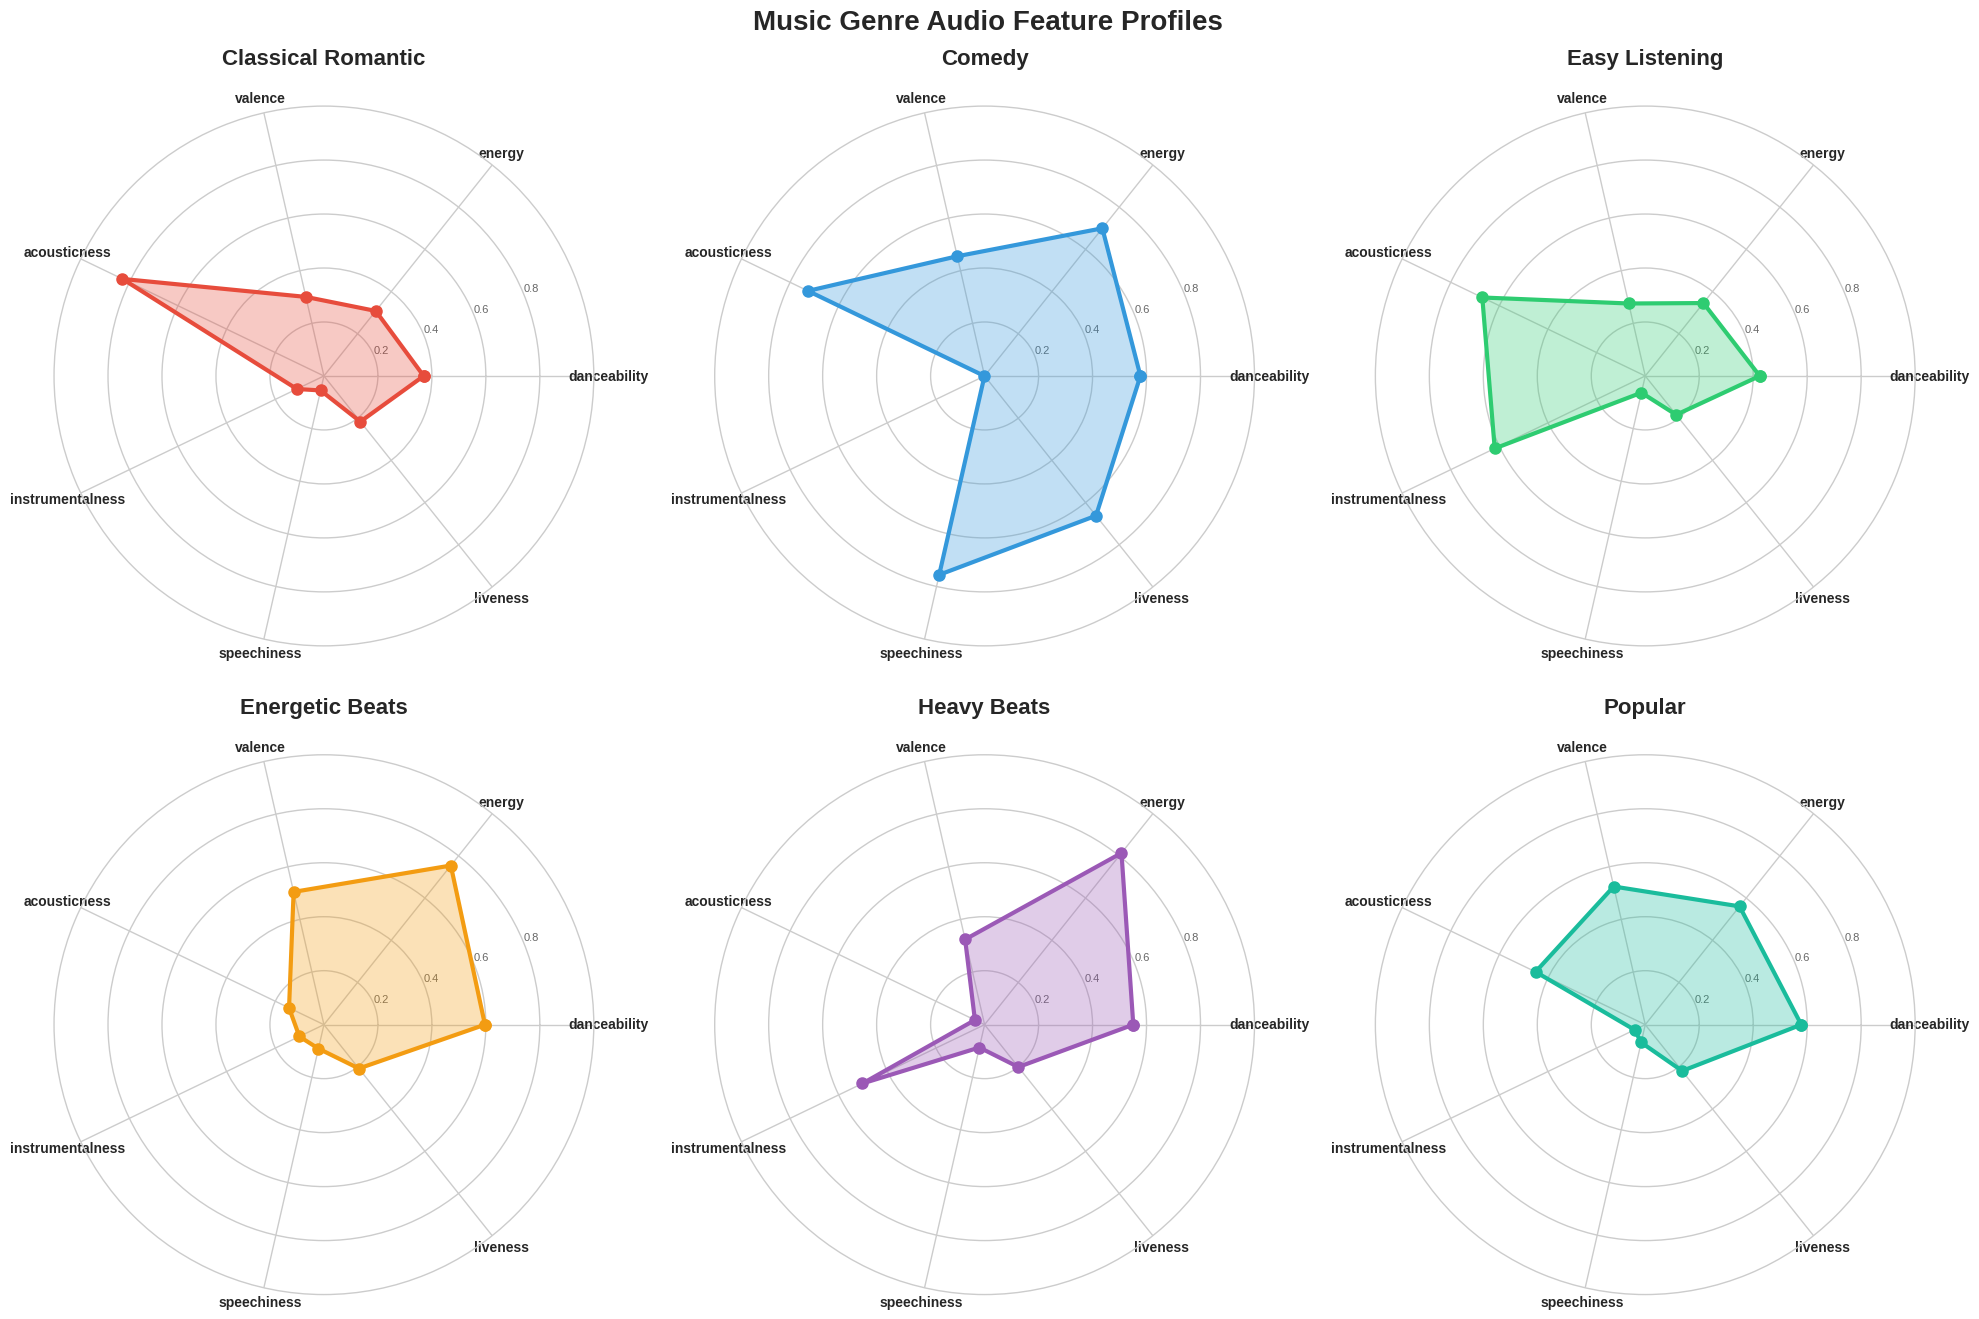

In [183]:
def create_genre_radar_subplots(genre_data):
    """Create beautiful static radar chart subplots with enhanced styling"""
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    genres = list(genre_data.index)
    features = list(genre_data.columns)
    
    # Calculate angles
    angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
    angles += angles[:1]
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 14), subplot_kw=dict(projection='polar'))
    axes = axes.flatten()
    
    # Specific color palette
    colors = ['#E74C3C', '#3498DB', '#2ECC71', '#F39C12', '#9B59B6', '#1ABC9C']
    
    for i, genre in enumerate(genres):
        ax = axes[i]
        
        # Get values and close the shape
        values = list(genre_data.loc[genre])
        values += values[:1]
        
        # Create the radar plot
        ax.plot(angles, values, 'o-', linewidth=3, 
               color=colors[i % len(colors)], markersize=8)
        ax.fill(angles, values, alpha=0.3, color=colors[i % len(colors)])
        
        # Customize appearance
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(features, fontsize=10, fontweight='semibold')
        ax.set_ylim(0, 1)
        
        # Enhanced title with emoji
        ax.set_title(f'{genre.title()}', 
                    fontsize=16, fontweight='bold', pad=30)
        
        # Custom grid
        ax.set_rticks([0.2, 0.4, 0.6, 0.8])
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8], 
                     labels=['0.2', '0.4', '0.6', '0.8'], 
                     fontsize=8, alpha=0.7)
        ax.grid(True, alpha=1)
        
    # Hide unused subplots
    for j in range(len(genres), 6):
        axes[j].set_visible(False)
    
    # Main title
    fig.suptitle('Music Genre Audio Feature Profiles', 
                fontsize=20, fontweight='bold', y=0.95)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Usage
create_genre_radar_subplots(genre_profiles)
